In [1]:
import matplotlib.pyplot as plt 
import numpy as np 

import torch
from torch import nn, optim
from torch.autograd import variable
import torch.nn.functional as F 

import torchvision
from torchvision import datasets, transforms, models

from PIL import Image

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = './Data'

def load_split_train_test(data_dir, valid_size = 0.2):

    train_transforms = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.Resize(224),
                                           transforms.ToTensor(),
                                          ])
    test_transforms = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.Resize(224),
                                           transforms.ToTensor(),
                                          ])

    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

    num_train = len(train_data)

    indices = list(range(num_train))

    split = int(np.floor(valid_size * num_train))

    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    train_idx, test_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler= train_sampler, batch_size = 16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size = 16)

    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)



['Basalt', 'Highland']


In [8]:
 test_transforms = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.Resize(224),
                                           transforms.ToTensor(),
                                          ]) 
                                          
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler

    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler = sampler , batch_size = num)

    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

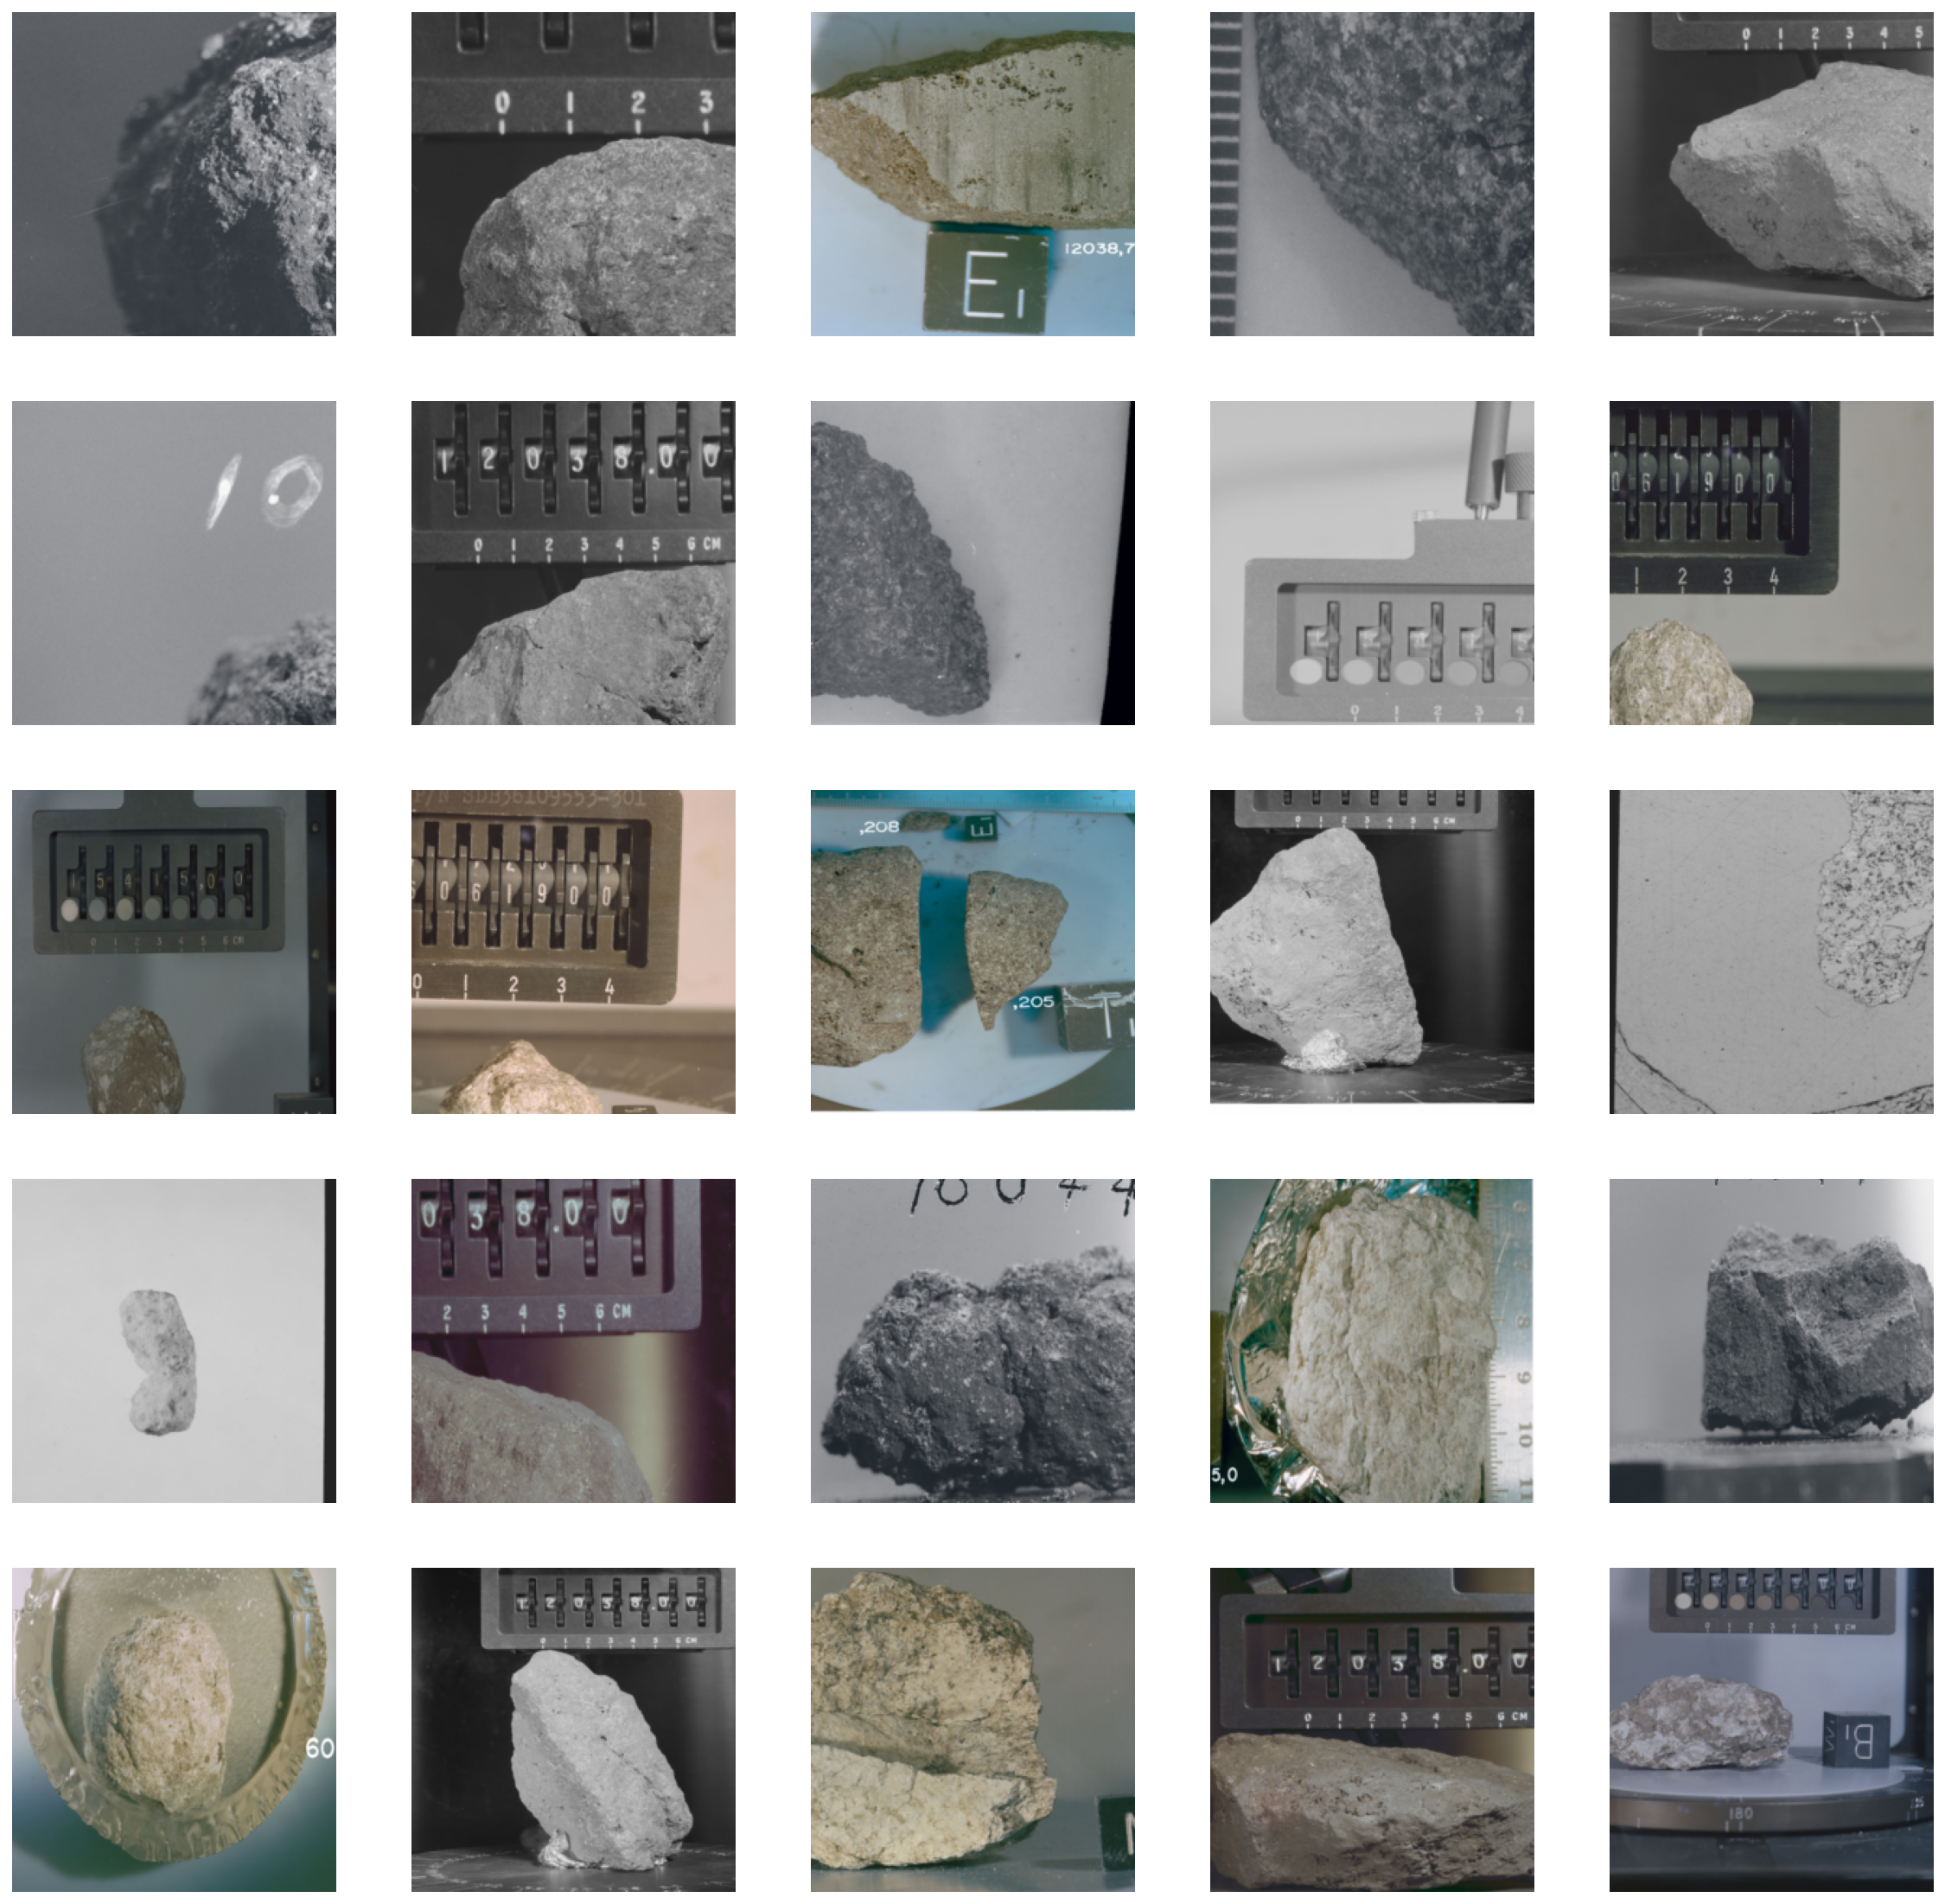

In [9]:
images, labels = get_random_images(25)

to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))

classes = trainloader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(5, 5, ii +1)
    plt.axis('off')
    plt.imshow(image)

plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\apguz/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [13]:
#Built Neurons 
for param in model.parameters():
    param.requires_grad = False

#wire the neurons to do the NN
model.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512,2),
                        nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

#add the NN to the device
model.to(device)

print('done')

done


In [28]:
#number of iterations
epochs = 5
print_every  = 5

#Loss variables
running_loss = 0
train_losses, test_losses = [], []

#track the training
steps = 0

for epoch in range(epochs):
    epoch += 1

    for inputs, labels in trainloader:
        steps += 1
        print('Training step', steps)

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() #zero out the gradiants avoiding the acumulation
        logps = model.forward(inputs) #pass the images through the model, return the log probabilities of each label
        loss = criterion(logps, labels) #run the log probabilites through the criterios to get the output graph
        loss.backward()#use the loss grpah to compute gradients
        optimizer.step()#update the parameters based on the current gradient
        running_loss += loss.item()# add the loss number to the running loss total

        if steps % print_every == 0:

            test_loss = 0
            accuracy = 0

            model.eval()

            with torch.no_grad():#refine the accuracy of the prediction without updating the gradients
                for inputs, labels in testloader:

                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps) #return a new tensor with the true probabilites
                    top_p, top_class = ps.topk(1, dim = 1) # retrun the largest probability and class o the nuew tensor along a given dimension
                    equals = top_class == labels.view(*top_class.shape) #reshape the tensor to match the same shape as the top class
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item() #compute the accuracy and add it to the running accuracy count for the test batch

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print(f"\n     Epoch {epoch}/{epochs}: "
               f"Train loss: {running_loss/print_every:.3f}.. "
               f"Test loss: {test_loss/len(testloader):.3f}.. "
               f"Test accuracy: {accuracy/len(testloader):.3f}\n")
            
            running_loss = 0
            model.train()

            break


Training step 1
Training step 2
Training step 3
Training step 4
Training step 5

     Epoch 1/5: Train loss: 0.183.. Test loss: 0.094.. Test accuracy: 0.933

Training step 6
Training step 7
Training step 8
Training step 9
Training step 10

     Epoch 2/5: Train loss: 0.178.. Test loss: 0.179.. Test accuracy: 0.904

Training step 11
Training step 12
Training step 13
Training step 14
Training step 15

     Epoch 3/5: Train loss: 0.366.. Test loss: 0.171.. Test accuracy: 0.935

Training step 16
Training step 17
Training step 18
Training step 19
Training step 20

     Epoch 4/5: Train loss: 0.200.. Test loss: 0.164.. Test accuracy: 0.904

Training step 21
Training step 22
Training step 23
Training step 24
Training step 25

     Epoch 5/5: Train loss: 0.118.. Test loss: 0.101.. Test accuracy: 0.967



In [29]:
print(accuracy/len(testloader))

0.9666666686534882


In [31]:
torch.save(model, 'aerialmodel.pth')